In [79]:
import pandas as pd
import glob
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from bagpipe.preprocessing import ApplyThreshold, _ConcatDataFrames
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import plot_importance

set_config(display="diagram")

In [47]:
train_dflist = []
for i, fname in enumerate(sorted(glob.glob("../data/2013_Targa_Sixty_Six" + "/*.csv"))):
    train_dflist.append(pd.read_csv(fname, sep=","))
    
test_dflist = []
for i, fname in enumerate(sorted(glob.glob("../data/2013_Laguna_Seca" + "/*.csv"))):
    test_dflist.append(pd.read_csv(fname, sep=","))

In [48]:
columns_to_standardize = [
    "engineSpeed",
    "handwheelAngle",
    "throttle",
    "brake",
    "axCG",
    "ayCG",
    "yawRate",
    "chassisAccelFL",
    "chassisAccelFR",
    "chassisAccelRL",
    "chassisAccelRR",
]

In [49]:
ct = ColumnTransformer([("stand", StandardScaler(), columns_to_standardize)],
                       remainder="passthrough",
                       verbose_feature_names_out=False)

pipeline = Pipeline([('threshold', ApplyThreshold(threshold=10, by="vxCG", seq_length=1)), 
                     ('concat', _ConcatDataFrames()), 
                     ("stand", ct.set_output(transform="pandas"))])
pipeline

Pipeline(steps=[('threshold', ApplyThreshold(by='vxCG', threshold=10)),
                ('concat', _ConcatDataFrames()),
                ('stand',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('stand', StandardScaler(),
                                                  ['engineSpeed',
                                                   'handwheelAngle', 'throttle',
                                                   'brake', 'axCG', 'ayCG',
                                                   'yawRate', 'chassisAccelFL',
                                                   'chassisAccelFR',
                                                   'chassisAccelRL',
                                                   'chassisAccelRR'])],
                                   verbose_feature_names_out=False))])

In [61]:
train_dataframe = pipeline.fit_transform(train_dflist)
test_dataframe = pipeline.transform(test_dflist)

In [62]:
train_dataframe.drop(["time", "longitude", "latitude"], inplace = True, axis = 1)
test_dataframe.drop(["time", "longitude", "latitude"], inplace = True, axis = 1)

y_train = train_dataframe["sideSlip"]
X_train = train_dataframe.drop(["sideSlip", "vxCG", "vyCG"], axis = 1)

y_test = train_dataframe["sideSlip"]
X_test = train_dataframe.drop(["sideSlip", "vxCG", "vyCG"], axis = 1)

In [74]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# fit model
model.fit(X_train, y_train)
# make predictions
preds = model.predict(X_test)

In [75]:
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Mean absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean absolute Error: 0.06387520893389367
Mean Squared Error: 0.007535598540552144
R-squared Score: 0.9906350978260019


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

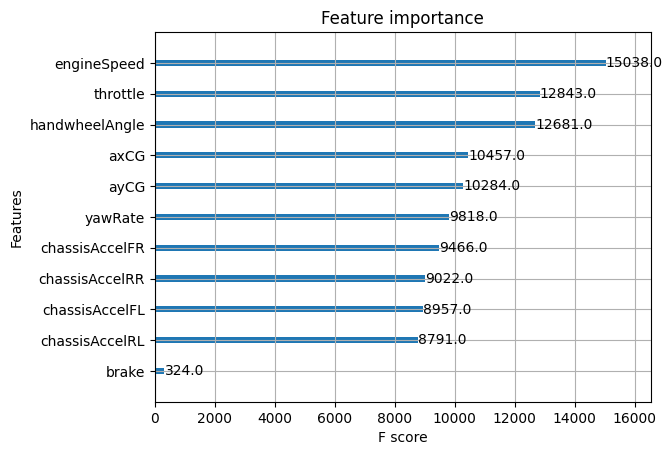

In [80]:
plot_importance(model)